# Imports

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import time
import collections
from typing import Dict
from typing import List
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import imp
%matplotlib inline

import sys
sys.path.insert(0, '../../../src/')

import network_utils
import utils

# Helper functions

In [2]:
def reload():
    imp.reload(network_utils)
    imp.reload(utils)

# Parameters

In [3]:
weeks = 12

# Data loading

In [4]:
original_data = pd.read_csv(
    '../../../data/Countries/events.1995.20150313082510.tab', sep='\t')

event_dates = []
for i in range(len(original_data)):
    event_dates.append(
        datetime.datetime.strptime(
            original_data.iloc[i]['Event Date'], '%Y-%m-%d').date())
original_data['Event Date'] = event_dates

original_data.rename(index=str, columns={
    'Event Date': 'edge_date',
    'Source Country': 'source',
    'Target Country': 'target',
    'Intensity': 'weight'}, inplace=True)

In [5]:
data = original_data[
    ['edge_date', 'source', 'target', 'weight']]

In [6]:
# Removes the messages from/to unkown or not-country origin.
data.dropna(inplace=True)

# Removes all self-edges.
sources = data['source']
targets = data['target']

to_be_deleted = []
for i in range(len(data)):
    if sources[i] == targets[i]:
        to_be_deleted.append(i)
data.drop(data.index[to_be_deleted], inplace=True)

/home/omid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/omid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [7]:
data.head()

,edge_date,source,target,weight
1,1995-01-01,Bosnia and Herzegovina,Serbia,4.0
2,1995-01-01,Serbia,Bosnia and Herzegovina,4.0
10,1995-01-01,Russian Federation,United States,4.0
18,1995-01-01,Hong Kong,Singapore,3.4
19,1995-01-01,Jordan,Israel,8.0


In [8]:
print('How many edges are given from a source to target more than once over time: ',
      len(np.where(data[['source', 'target']].duplicated())[0]))

How many edges are given from a source to target more than once over time:  70895


# Data basic analysis

In [9]:
data_len = len(data)
print('Data has {} #edges.\nIt spans from {} to {}.\n'
      'It has {} #nodes (unique) in total duration.'.format(
          data_len,
          min(data['edge_date']),
          max(data['edge_date']),
          len(set(data['source']).union(set(data['target'])))))

pos = len(np.where(data['weight'] > 0)[0])
neg = len(np.where(data['weight'] < 0)[0])
zer = len(np.where(data['weight'] == 0)[0])  # It should not be any zeros.
print('\nEdge (trust/distrust) over time:\n\t+:'
      ' {}({}%)\n\t-: {}({}%)\n\t0: {}({}%).'.format(
          pos, round(100*pos/data_len),
          neg, round(100*neg/data_len),
          zer, round(100*zer/data_len)))

Data has 76556 #edges.
It spans from 1995-01-01 to 1995-12-31.
It has 216 #nodes (unique) in total duration.

Edge (trust/distrust) over time:
	+: 55893(73%)
	-: 13149(17%)
	0: 7514(10%).


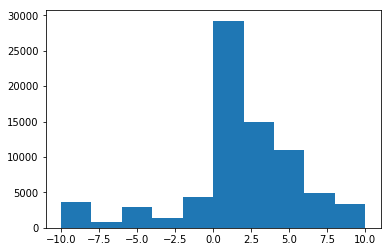

In [10]:
plt.hist(data['weight']);

# Extracting the networks

In [11]:
separate_dgraphs = network_utils.extract_graphs(edge_list=data, weeks=weeks, accumulative=False)
accumulative_dgraphs = network_utils.extract_graphs(edge_list=data, weeks=weeks, accumulative=True)

# Plotting

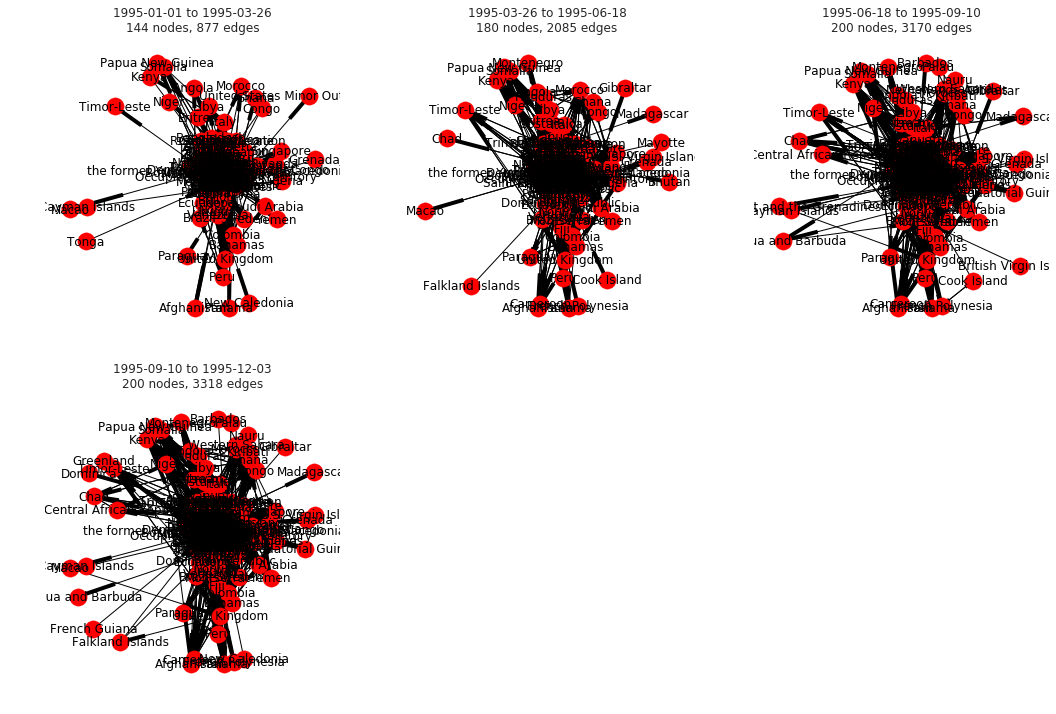

In [12]:
# Just to create title names.
title_names = []
start_date = min(data['edge_date'])
end_date = max(data['edge_date'])
periods_num = int(np.floor((end_date - start_date).days / (weeks * 7)))
for period_index in range(periods_num):
    period_start = (
        start_date + period_index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    title_names.append('{} to {}'.format(period_start, period_end))

network_utils.plot_evolving_graphs(dgraphs=separate_dgraphs, titles=title_names)

# Computing the metrics for networks in periods

## Metrics for separate dynamic graphs

### Goodness and fairness of nodes

In [13]:
fg_metrics = []
for dgraph in separate_dgraphs:
    fg_metrics.append(
        network_utils.compute_fairness_goodness(dgraph, verbose=False))

### All metrics

In [14]:
sorted_keys = sorted(
    network_utils.get_metrics_for_network(separate_dgraphs[0]).keys())

evolving_metrics = collections.defaultdict(list)
for index, directed_graph in enumerate(separate_dgraphs):
    print(index, '...')
    metrics = network_utils.get_metrics_for_network(directed_graph)
    for key in sorted_keys:
        evolving_metrics[key].append(metrics[key])

0 ...
1 ...
2 ...
3 ...


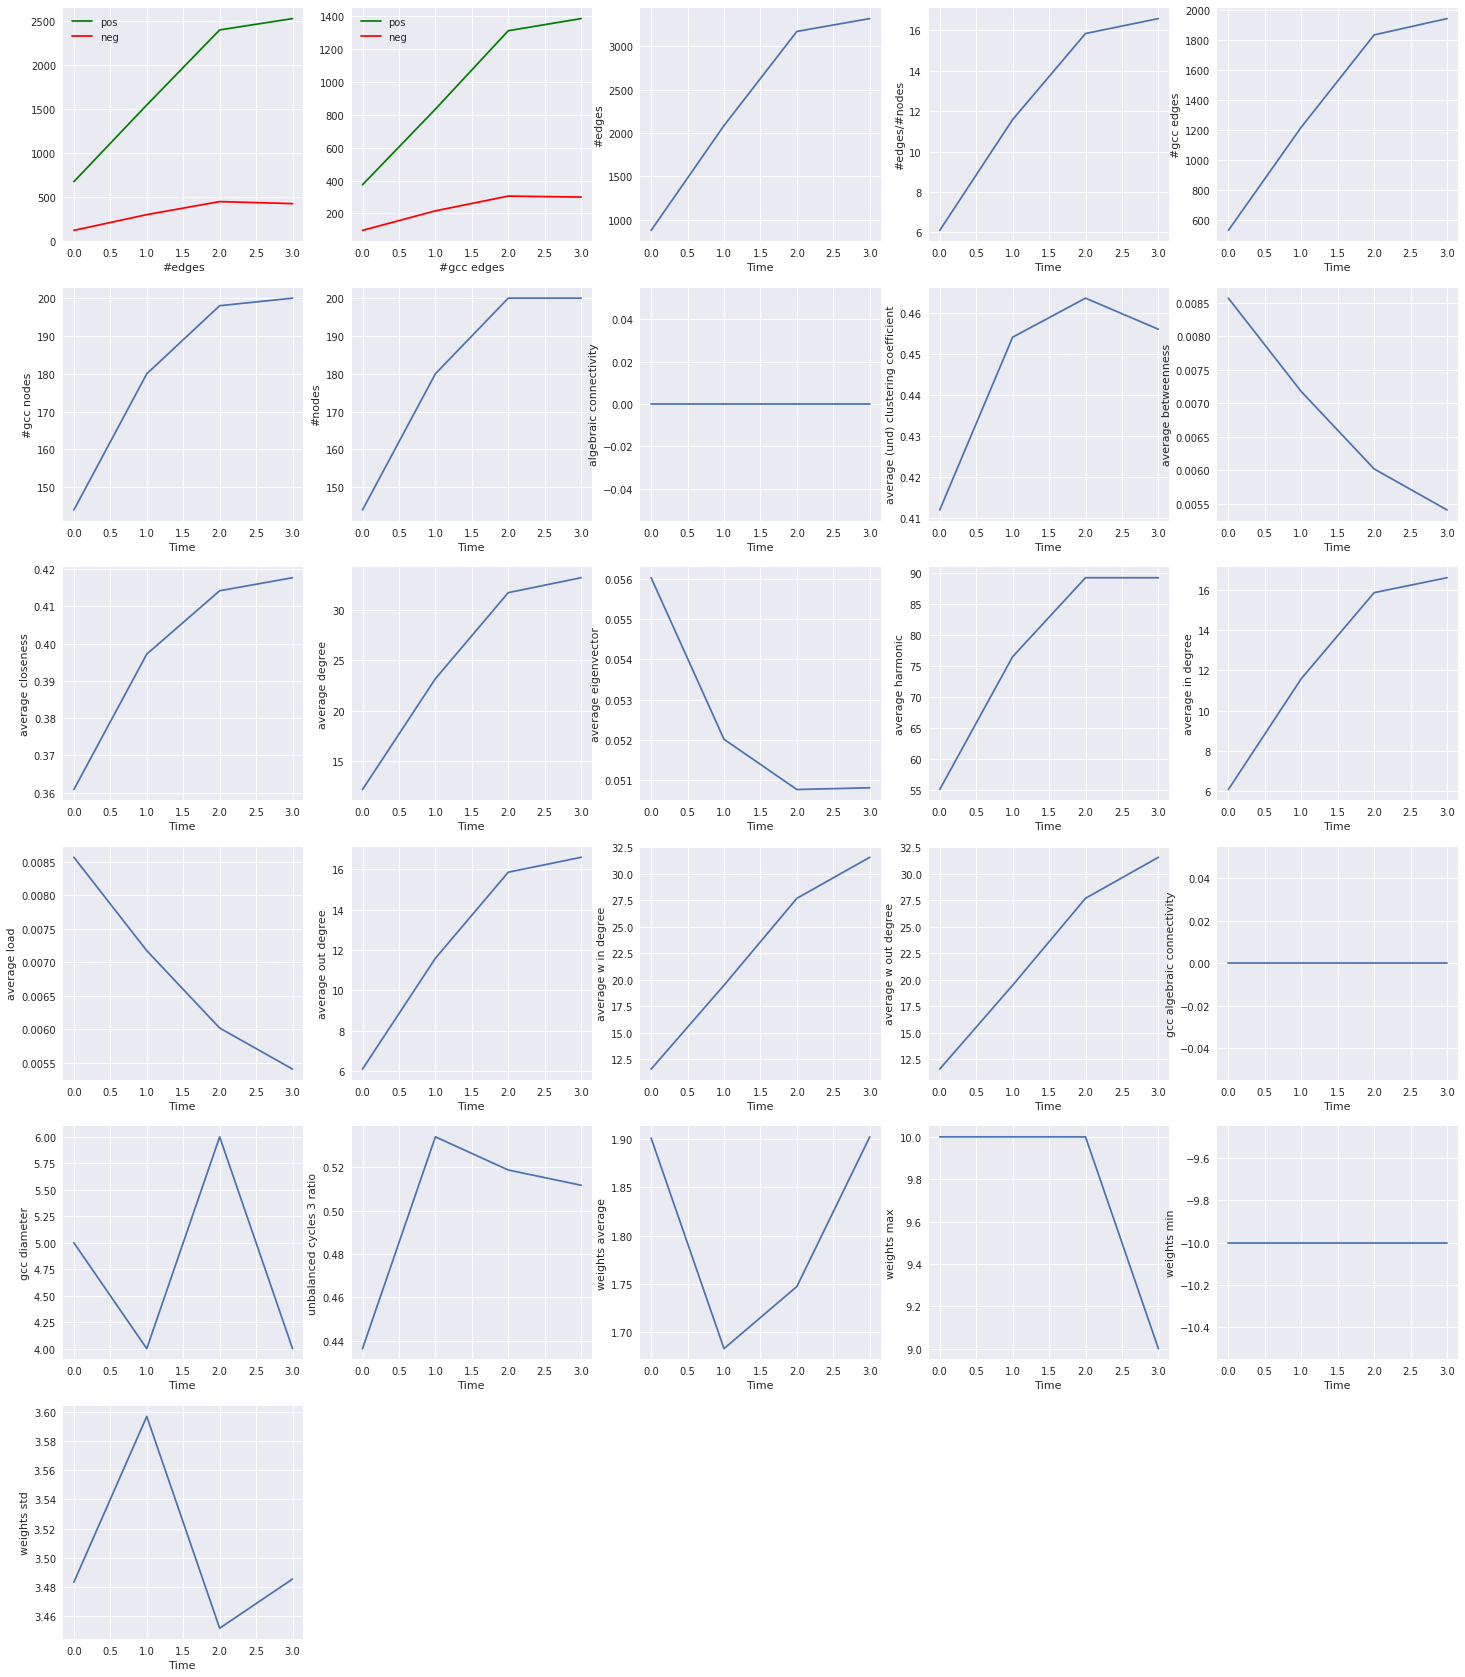

In [15]:
m = 6
n = 5
sns.set(rc={'figure.figsize':(25, 30)})

sorted_keys = sorted(list(
    set(evolving_metrics.keys()) - set([
        '#pos edges', '#neg edges', '#gcc pos edges', '#gcc neg edges'])))

plt.subplot(m, n, 1)
plt.plot(evolving_metrics['#pos edges'], 'g')
plt.plot(evolving_metrics['#neg edges'], 'r')
plt.xlabel('#edges')
plt.legend(['pos', 'neg'])

plt.subplot(m, n, 2)
plt.plot(evolving_metrics['#gcc pos edges'], 'g')
plt.plot(evolving_metrics['#gcc neg edges'], 'r')
plt.xlabel('#gcc edges')
plt.legend(['pos', 'neg'])

for index, key in enumerate(sorted_keys):
    plt.subplot(m, n, index+3)
    plt.plot(evolving_metrics[key])
    plt.ylabel(key)
    plt.xlabel('Time')

### Metrics for accumulative dynamic graphs

In [16]:
sorted_keys = sorted(
    network_utils.get_metrics_for_network(accumulative_dgraphs[0]).keys())

accumulative_evolving_metrics = collections.defaultdict(list)
for index, accumulative_dgraph in enumerate(accumulative_dgraphs):
    print(index, '...')
    metrics = network_utils.get_metrics_for_network(accumulative_dgraph)
    for key in sorted_keys:
        accumulative_evolving_metrics[key].append(metrics[key])

0 ...
1 ...
2 ...
3 ...


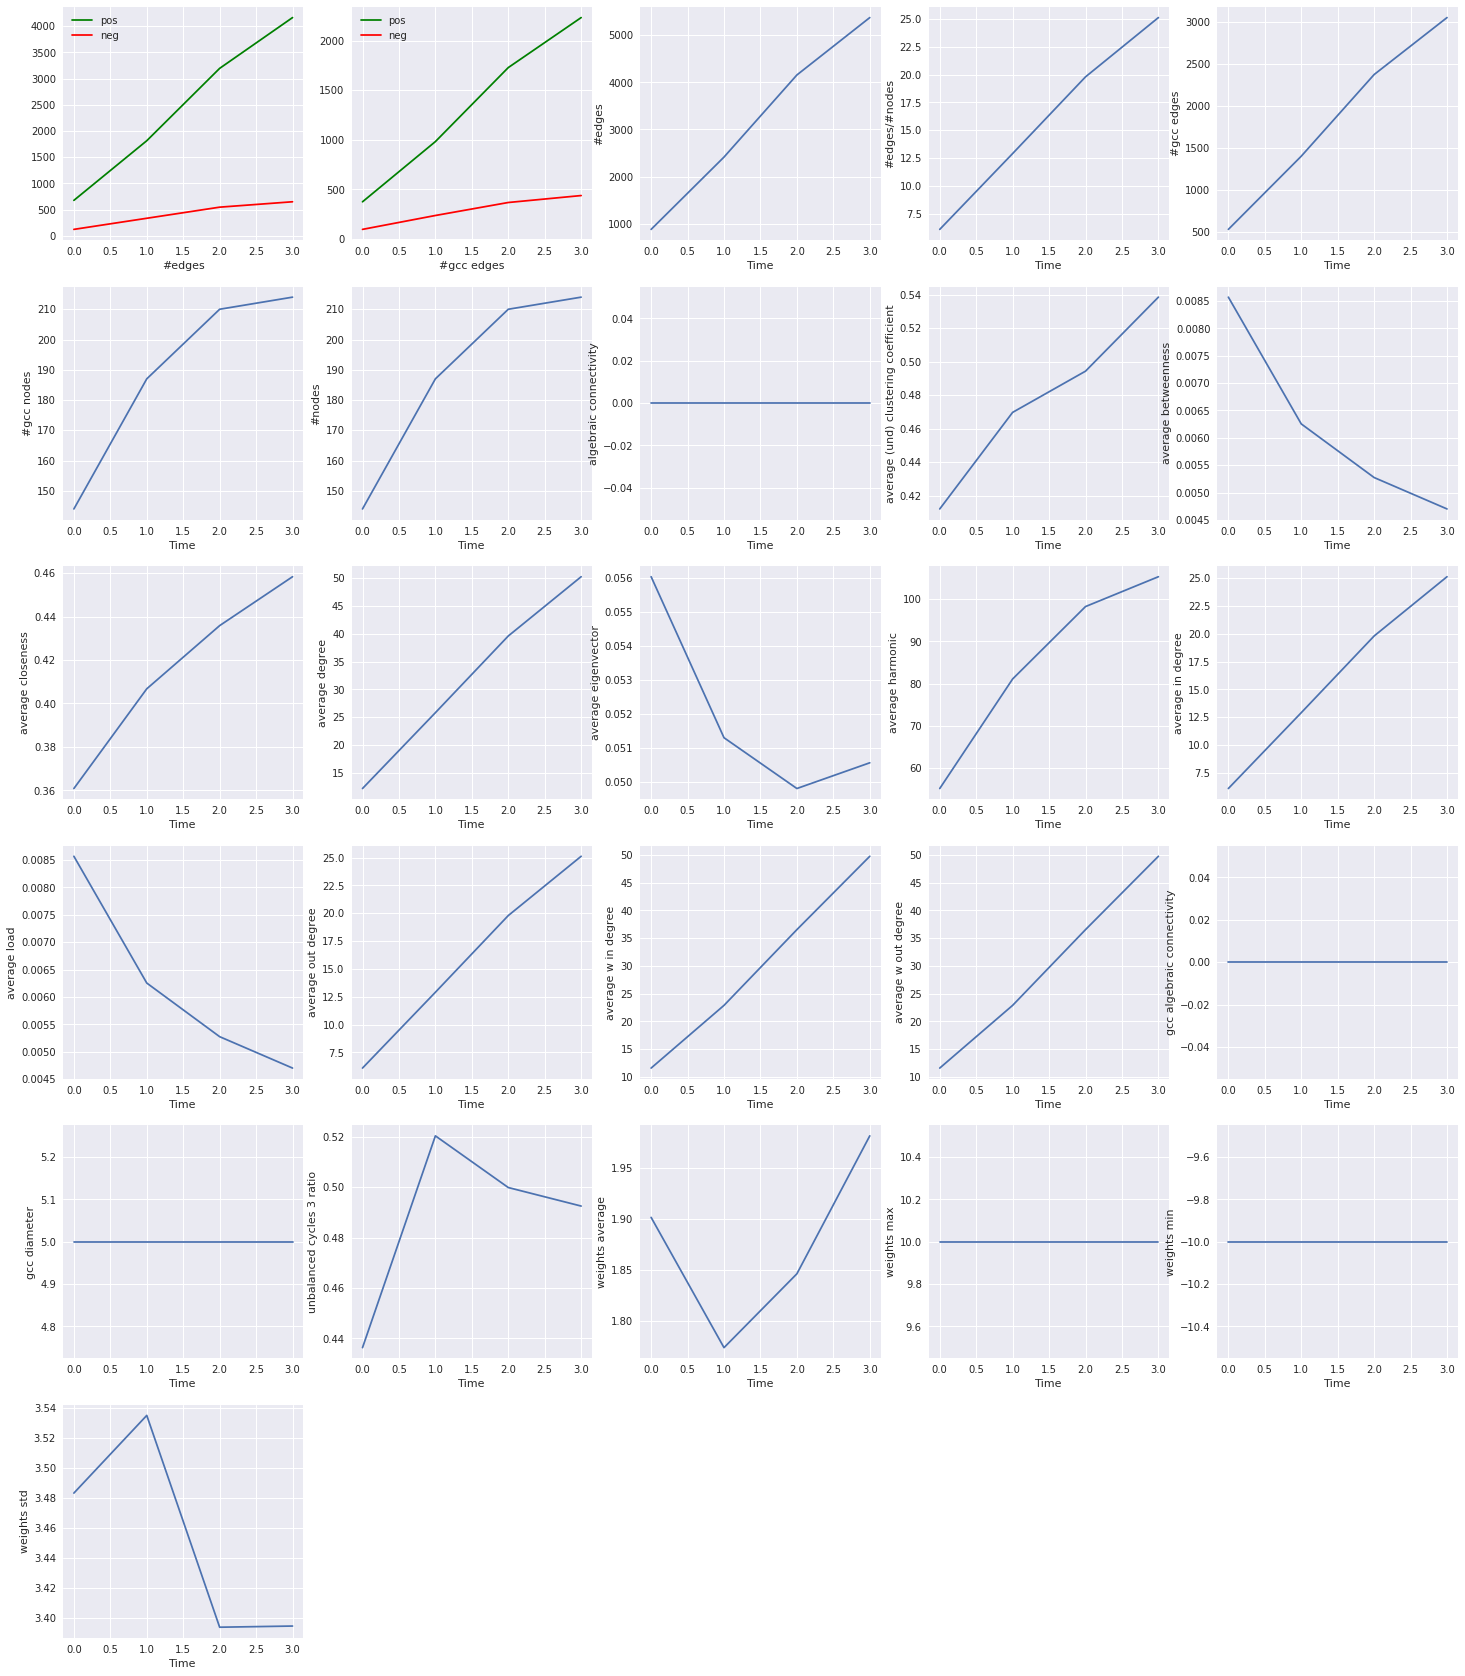

In [17]:
m = 6
n = 5
sns.set(rc={'figure.figsize':(25, 30)})

sorted_keys = sorted(list(
    set(accumulative_evolving_metrics.keys()) - set([
        '#pos edges', '#neg edges', '#gcc pos edges', '#gcc neg edges'])))

plt.subplot(m, n, 1)
plt.plot(accumulative_evolving_metrics['#pos edges'], 'g')
plt.plot(accumulative_evolving_metrics['#neg edges'], 'r')
plt.xlabel('#edges')
plt.legend(['pos', 'neg'])

plt.subplot(m, n, 2)
plt.plot(accumulative_evolving_metrics['#gcc pos edges'], 'g')
plt.plot(accumulative_evolving_metrics['#gcc neg edges'], 'r')
plt.xlabel('#gcc edges')
plt.legend(['pos', 'neg'])

for index, key in enumerate(sorted_keys):
    plt.subplot(m, n, index+3)
    plt.plot(accumulative_evolving_metrics[key])
    plt.ylabel(key)
    plt.xlabel('Time')

# Van de Rijt balance

## Separated graphs

In [18]:
start_time = time.time()

edge_balances = []
for separate_dgraph in separate_dgraphs:
    edge_balances.append(
        network_utils.compute_edge_balance(separate_dgraph))

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')

It took : 0.16383424599965413 mins.


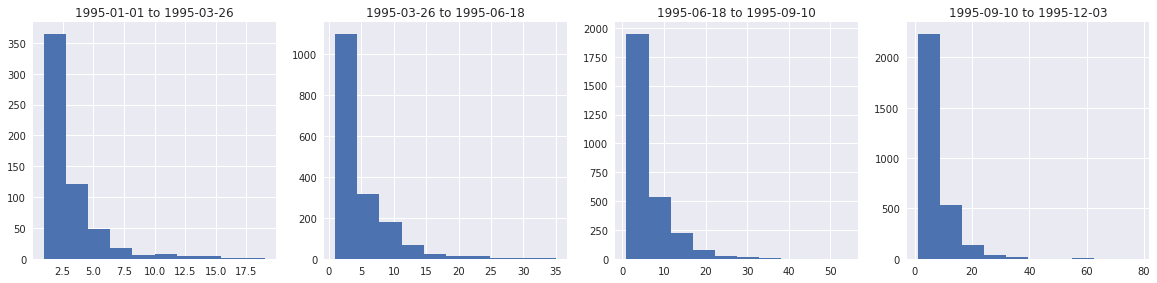

In [19]:
m = 4
n = 4
sns.set(rc={'figure.figsize':(20, 20)})
for index, edge_balance in enumerate(edge_balances):
    num_unbalanced = []
    for value in edge_balance.values():
        num_unbalanced.append(
            value['#cycle3'] - value['#balanced'])
    plt.subplot(m, n, index + 1)
    if num_unbalanced:
        num_unbalanced = np.array(num_unbalanced)
        num_unbalanced = num_unbalanced[num_unbalanced.nonzero()]
    plt.hist(num_unbalanced)
    
    # Period.
    period_start = (
        start_date + index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    plt.title(
        '{} to {}'.format(str(period_start).split(' ')[0],
                          str(period_end).split(' ')[0]))

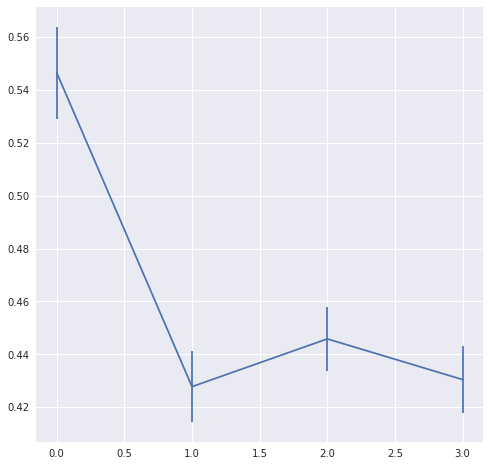

In [20]:
transitions_balance = collections.defaultdict(list)
# transitions_div_unbalance = collections.defaultdict(list)
for edge_balance in edge_balances:
    for key, value in edge_balance.items():
        transitions_balance[key].append(value['#balanced']/value['#cycle3'])
#         transitions_div_unbalance[key].append(1 - value['#balanced'] / value['#cycle3'])


balanced_cycle3_ratio = []
for val in transitions_balance.values():
    if len(val) > 3:
        balanced_cycle3_ratio.append(val)

sns.set(rc={'figure.figsize':(8, 8)})
balanced_cycle3_ratio = np.array(balanced_cycle3_ratio)
n, m =balanced_cycle3_ratio.shape
plt.errorbar(x=np.arange(0, m),
             y=np.mean(balanced_cycle3_ratio, axis=0),
             yerr=np.std(balanced_cycle3_ratio, axis=0)/np.sqrt(n));

## Accumulative graphs

In [21]:
accumulative_edge_balances = []
for accumulative_dgraph in accumulative_dgraphs:
    accumulative_edge_balances.append(
        network_utils.compute_edge_balance(accumulative_dgraph))

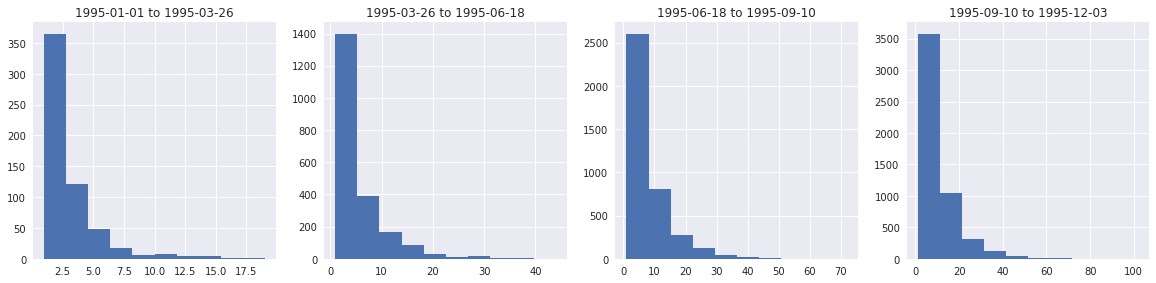

In [22]:
m = 4
n = 4
sns.set(rc={'figure.figsize':(20, 20)})
for index, accumulative_edge_balance in enumerate(accumulative_edge_balances):
    num_unbalanced = []
    for value in accumulative_edge_balance.values():
        num_unbalanced.append(
            value['#cycle3'] - value['#balanced'])
    plt.subplot(m, n, index + 1)
    if num_unbalanced:
        num_unbalanced = np.array(num_unbalanced)
        num_unbalanced = num_unbalanced[num_unbalanced.nonzero()]
    plt.hist(num_unbalanced)
    
    # Period.
    period_start = (
        start_date + index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    plt.title(
        '{} to {}'.format(str(period_start).split(' ')[0],
                          str(period_end).split(' ')[0]))

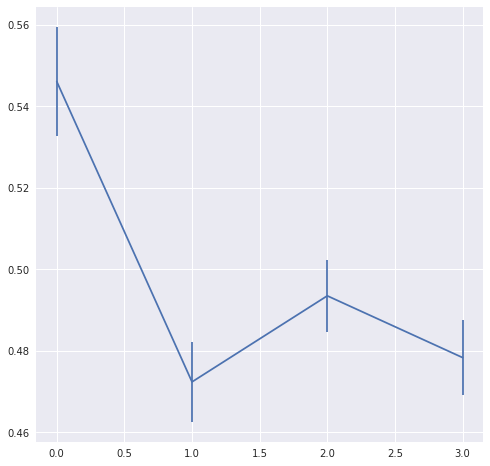

In [23]:
acc_transitions_balance = collections.defaultdict(list)
for accumulative_edge_balance in accumulative_edge_balances:
    for key, value in accumulative_edge_balance.items():
        acc_transitions_balance[key].append(value['#balanced'] / value['#cycle3'])

acc_balanced_cycle3_ratio = []
for val in acc_transitions_balance.values():
    if len(val) > 3:
        acc_balanced_cycle3_ratio.append(val)

sns.set(rc={'figure.figsize':(8, 8)})
acc_balanced_cycle3_ratio = np.array(acc_balanced_cycle3_ratio)
n, m = acc_balanced_cycle3_ratio.shape
plt.errorbar(x=np.arange(0, m),
             y=np.mean(acc_balanced_cycle3_ratio, axis=0),
             yerr=np.std(acc_balanced_cycle3_ratio, axis=0)/np.sqrt(n));

# Markov Chain of Sparse Triads

In [24]:
triad_map, triad_list = network_utils.generate_all_possible_sparse_triads()
unique_triad_num = len(triad_list)

### Transitive balanced

In [25]:
balanced = 0
for triad in triad_list:
    balanced += network_utils.is_transitive_balanced(triad)
print('Transitive balanced triads: ', balanced)
print('Out of triads: ', len(triad_list))

Transitive balanced triads:  23
Out of triads:  138


## Separated graphs

In [26]:
start_time = time.time()

result = network_utils.compute_transition_matrix(
    dgraphs=separate_dgraphs, unique_triad_num=unique_triad_num, triad_map=triad_map)

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')

../../../src/utils.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(matrix.T / np.sum(matrix, axis=1)).T


It took : 6.189279194672903 mins.


Nonzero percentage:  10.12 %


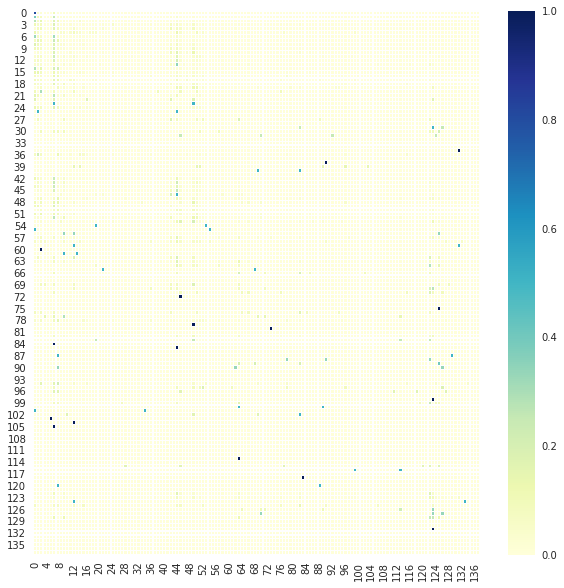

Nonzero percentage:  17.59 %


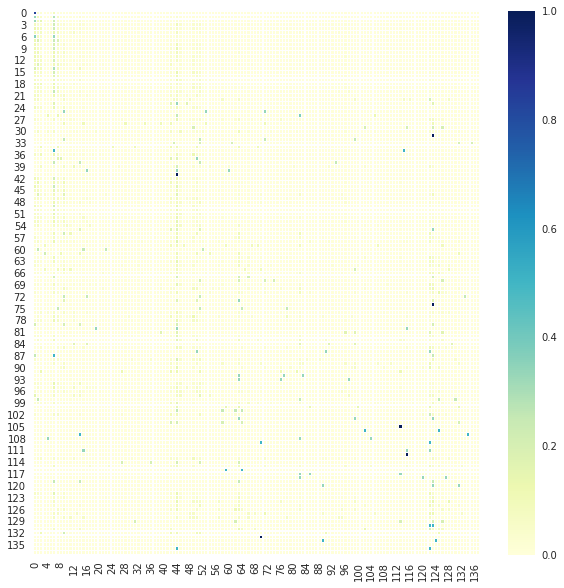

Nonzero percentage:  21.4 %


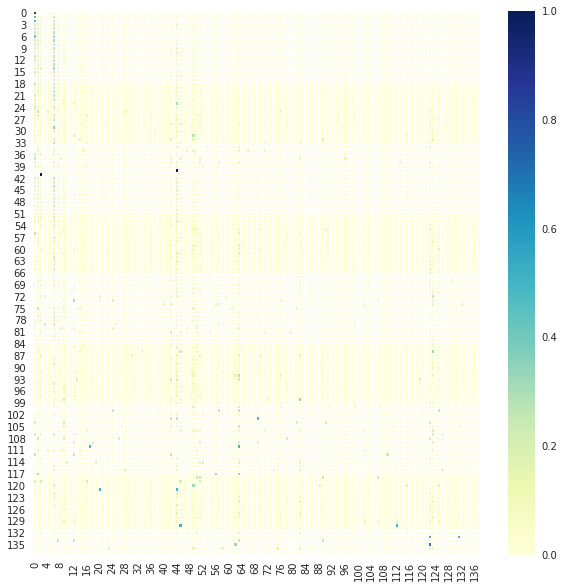

In [27]:
for transition_matrix in result['transition_matrices']:
    sns.set(rc={'figure.figsize': (10, 10)})
    print('Nonzero percentage: ', round(100 * len(np.where(transition_matrix > 0)[0]) / (unique_triad_num * unique_triad_num), 2), '%')
    sns.heatmap(transition_matrix, cmap="YlGnBu", linewidths=.1)
    plt.show()

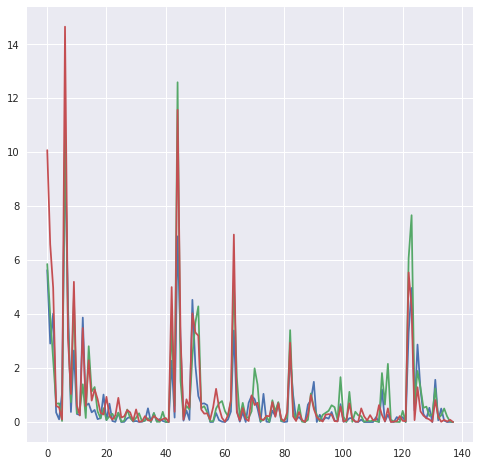

In [28]:
for transition_matrix in result['transition_matrices']:
    sns.set(rc={'figure.figsize': (8, 8)})
    plt.plot(np.sum(transition_matrix, axis=0))

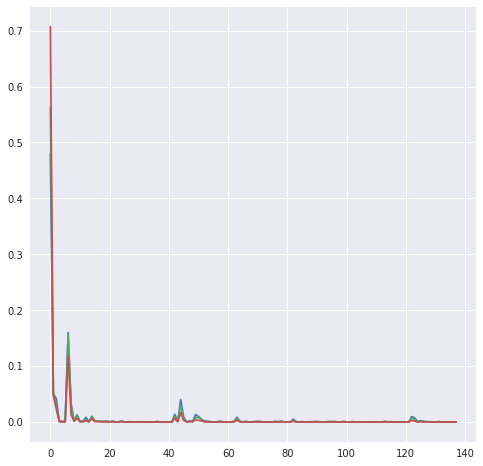

In [29]:
sns.set(rc={'figure.figsize': (8, 8)})
for transition_matrix in result['transition_matrices']:
    st_dist = network_utils.get_stationary_distribution(transition_matrix)
    plt.plot(st_dist)

In [30]:
mean_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
std_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
for i in range(unique_triad_num):
    for j in range(unique_triad_num):
        item_ij = []
        for matrix in result['transition_matrices']:
            item_ij.append(matrix[i, j])
        mean_transition_matrix[i, j] = np.mean(item_ij)
        std_transition_matrix[i, j] = np.std(item_ij)

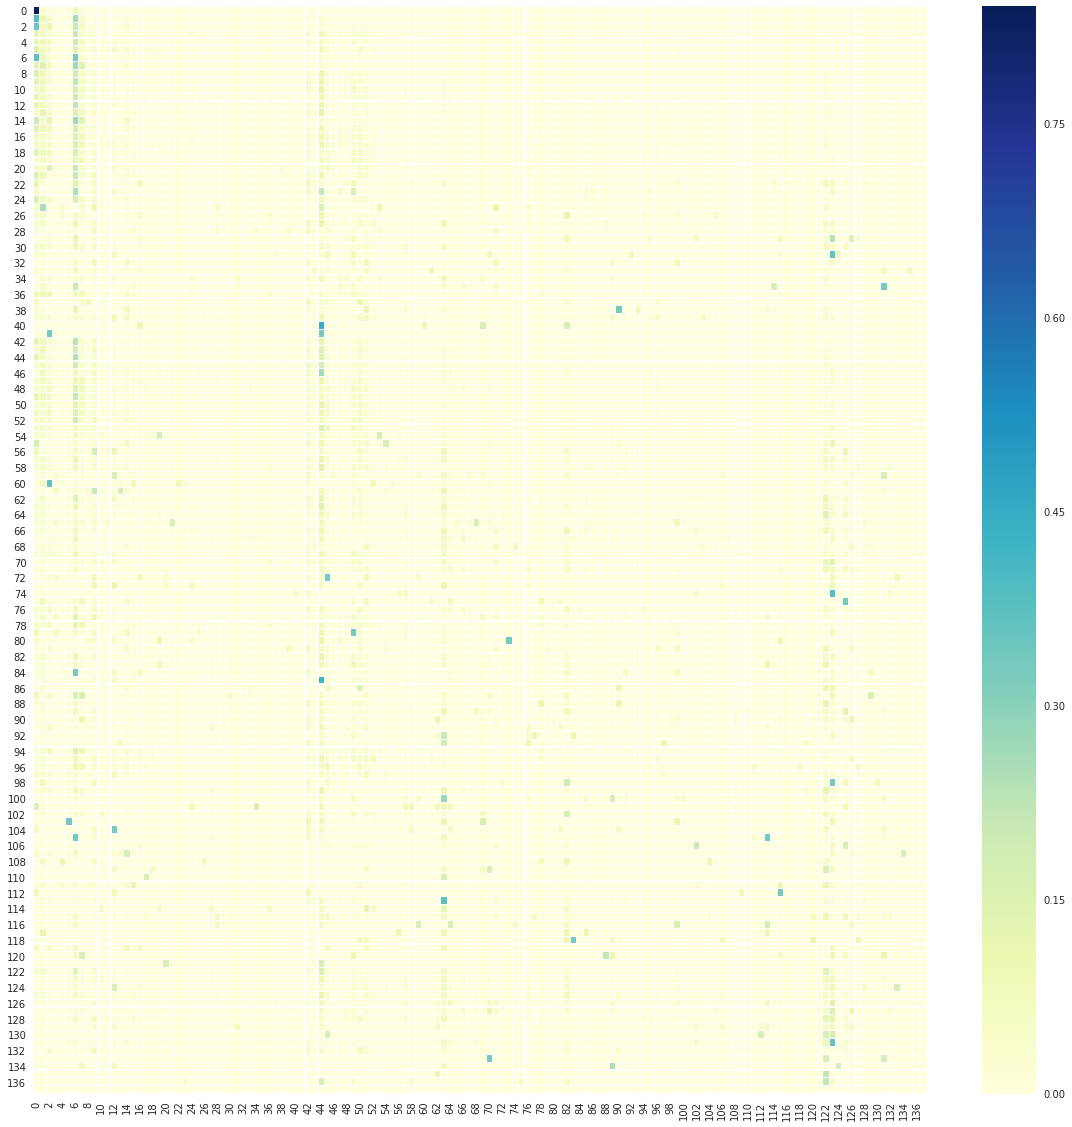

In [31]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(mean_transition_matrix, cmap="YlGnBu", linewidths=.1);

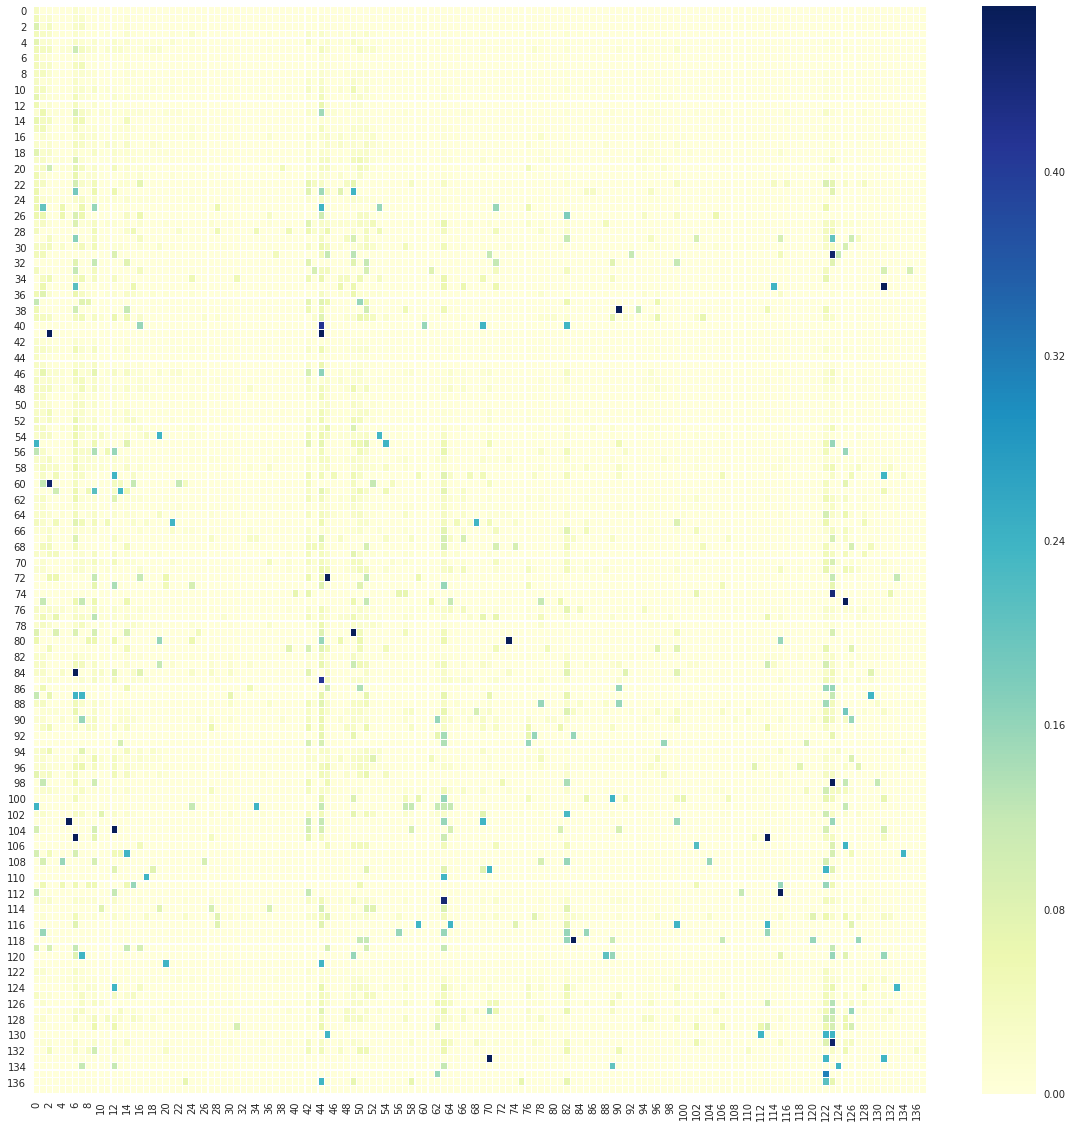

In [32]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(std_transition_matrix, cmap="YlGnBu", linewidths=.1);

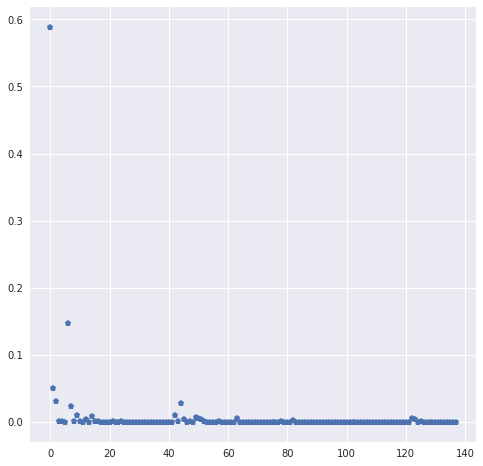

In [33]:
sns.set(rc={'figure.figsize': (8, 8)})
st_dist = network_utils.get_stationary_distribution(mean_transition_matrix)
plt.plot(st_dist, 'p');

In [34]:
print('Mixing time: ', np.real(network_utils.get_mixing_time_range(mean_transition_matrix)))

Mixing time:  42.384304874355394


In [35]:
for index in np.where(st_dist >= 0.1)[0]:
    print(triad_list[index])
    print('\n')

[[0 0 0]
 [0 0 0]
 [0 0 0]]


[[0 0 0]
 [0 0 1]
 [0 1 0]]




In [36]:
for index in np.where(st_dist >= np.mean(st_dist))[0]:
    print(triad_list[index])
    print('\n')

[[0 0 0]
 [0 0 0]
 [0 0 0]]


[[0 0 0]
 [0 0 0]
 [0 1 0]]


[[ 0  0  0]
 [ 0  0  0]
 [ 0 -1  0]]


[[0 0 0]
 [0 0 1]
 [0 1 0]]


[[ 0  0  0]
 [ 0  0  1]
 [ 0 -1  0]]


[[0 0 0]
 [0 0 1]
 [1 1 0]]


[[ 0  0  0]
 [ 0  0 -1]
 [ 0 -1  0]]


[[0 0 1]
 [0 0 1]
 [0 1 0]]


[[0 0 1]
 [0 0 1]
 [1 1 0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1  0  0]]




## Accumulated graphs 

In [37]:
start_time = time.time()

acc_result = network_utils.compute_transition_matrix(
    dgraphs=accumulative_dgraphs,
    unique_triad_num=unique_triad_num,
    triad_map=triad_map)

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')

../../../src/utils.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(matrix.T / np.sum(matrix, axis=1)).T


It took : 7.105812402566274 mins.


Nonzero percentage:  10.31 %


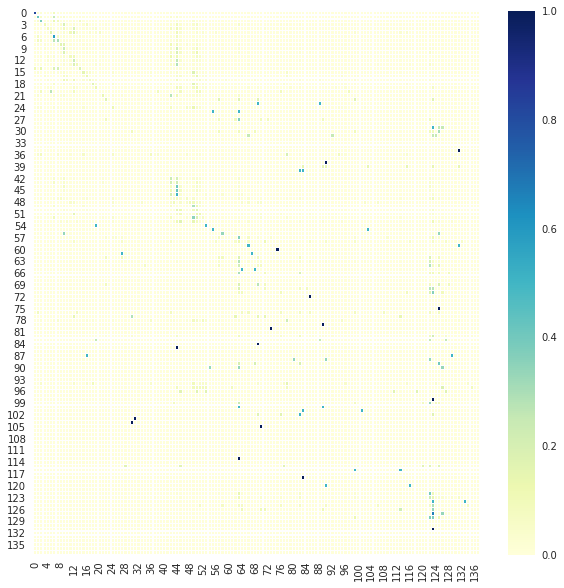

Nonzero percentage:  18.28 %


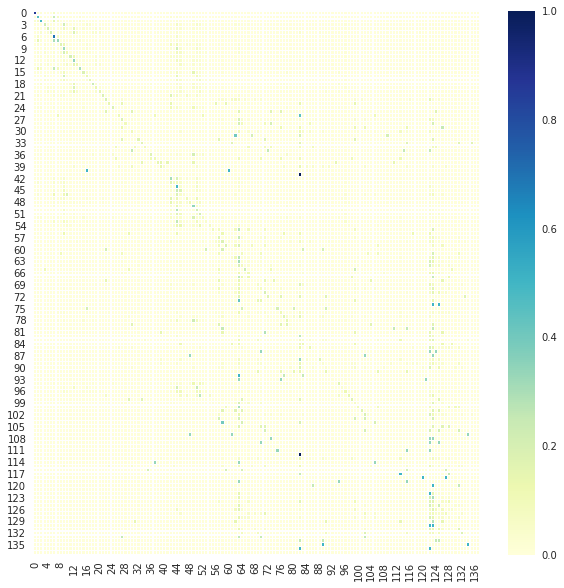

Nonzero percentage:  23.19 %


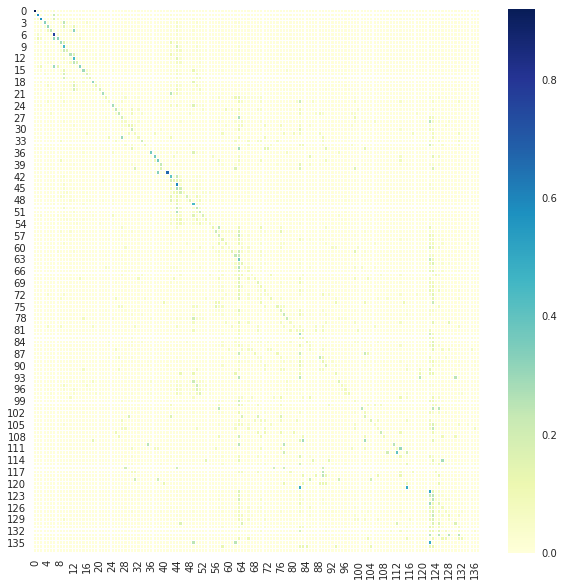

In [38]:
for transition_matrix in acc_result['transition_matrices']:
    sns.set(rc={'figure.figsize': (10, 10)})
    print('Nonzero percentage: ', round(100 * len(np.where(transition_matrix > 0)[0]) / (unique_triad_num * unique_triad_num), 2), '%')
    sns.heatmap(transition_matrix, cmap="YlGnBu", linewidths=.1)
    plt.show()

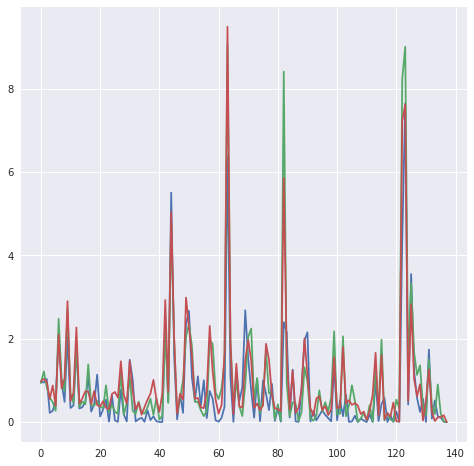

In [39]:
for transition_matrix in acc_result['transition_matrices']:
    sns.set(rc={'figure.figsize': (8, 8)})
    plt.plot(np.sum(transition_matrix, axis=0))

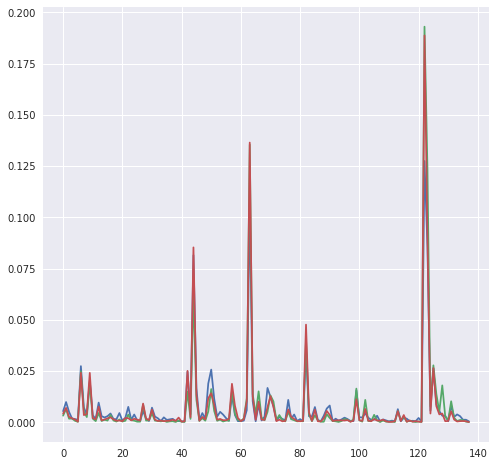

In [40]:
sns.set(rc={'figure.figsize': (8, 8)})
for transition_matrix in acc_result['transition_matrices']:
    st_dist = network_utils.get_stationary_distribution(transition_matrix)
    plt.plot(st_dist)

In [41]:
acc_mean_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
acc_std_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
for i in range(unique_triad_num):
    for j in range(unique_triad_num):
        item_ij = []
        for matrix in acc_result['transition_matrices']:
            item_ij.append(matrix[i, j])
        acc_mean_transition_matrix[i, j] = np.mean(item_ij)
        acc_std_transition_matrix[i, j] = np.std(item_ij)

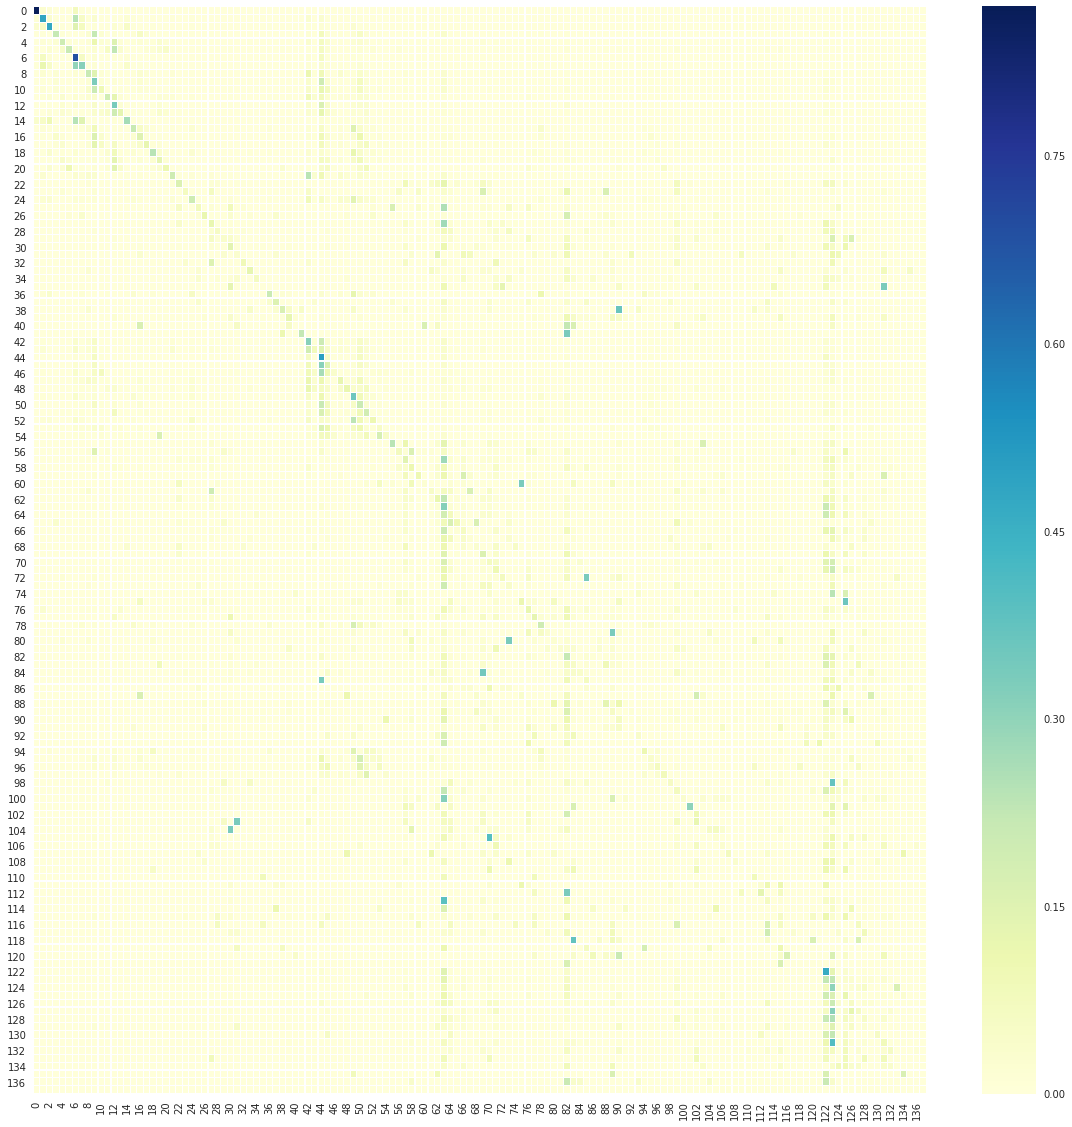

In [42]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(acc_mean_transition_matrix, cmap="YlGnBu", linewidths=.1);

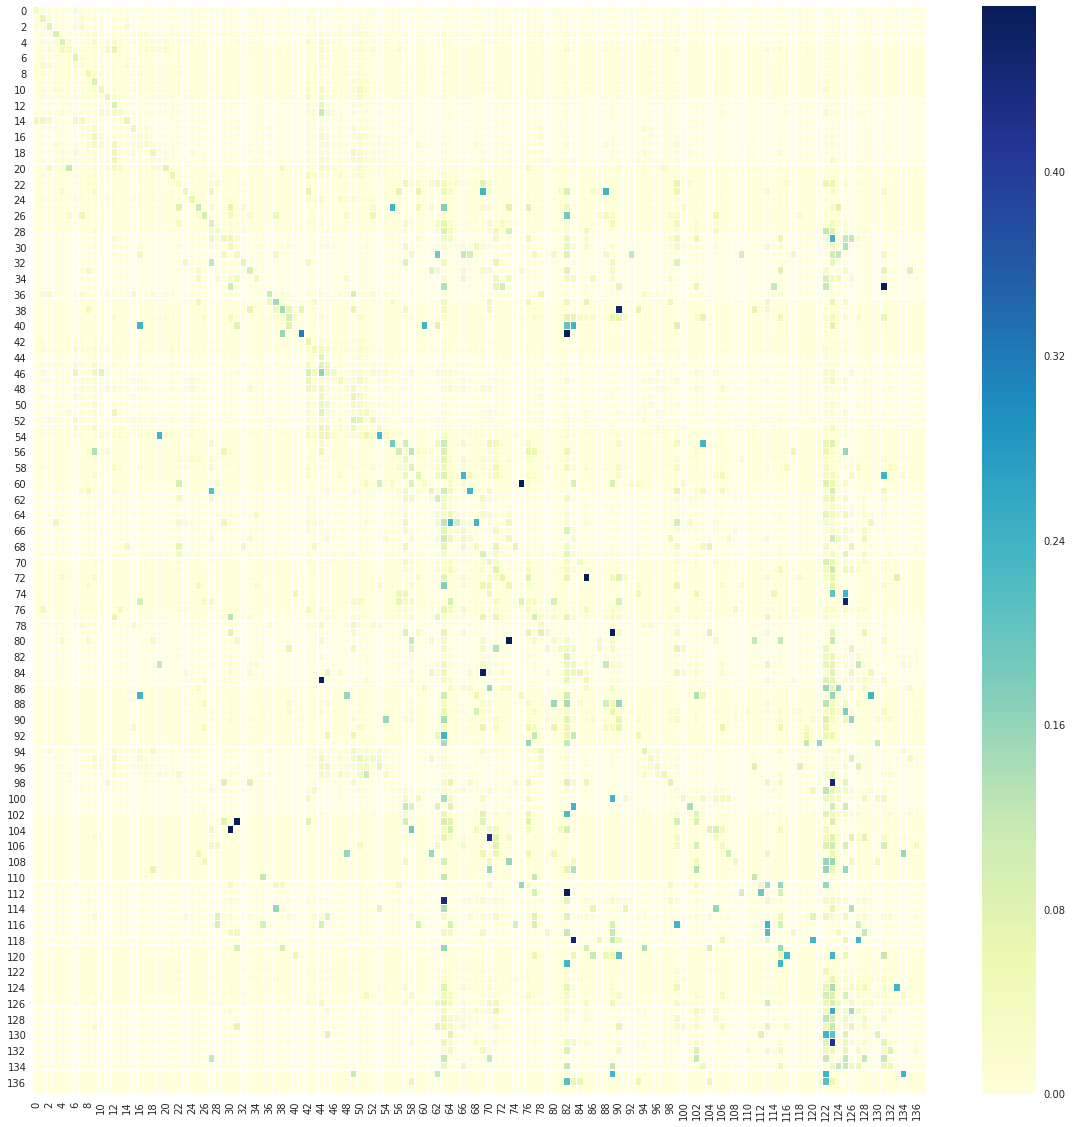

In [43]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(acc_std_transition_matrix, cmap="YlGnBu", linewidths=.1);

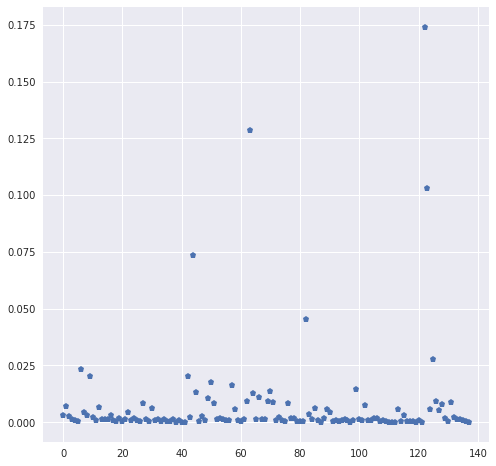

In [44]:
sns.set(rc={'figure.figsize': (8, 8)})
acc_st_dist = network_utils.get_stationary_distribution(acc_mean_transition_matrix)
plt.plot(acc_st_dist, 'p');

In [45]:
print('Mixing time: ', np.real(network_utils.get_mixing_time_range(acc_mean_transition_matrix)))

Mixing time:  115.06819207914195


In [46]:
for index in np.where(acc_st_dist >= 0.06)[0]:
    print(triad_list[index])
    print('\n')

[[0 0 1]
 [0 0 1]
 [1 1 0]]


[[0 0 1]
 [1 0 1]
 [1 1 0]]


[[0 1 1]
 [1 0 1]
 [1 1 0]]


[[ 0  1  1]
 [ 1  0  1]
 [ 1 -1  0]]




In [47]:
for index in np.where(acc_st_dist >= np.mean(acc_st_dist))[0]:
    print(triad_list[index])
    print('\n')

[[0 0 0]
 [0 0 1]
 [0 1 0]]


[[0 0 0]
 [0 0 1]
 [1 1 0]]


[[0 0 0]
 [1 0 1]
 [1 1 0]]


[[0 0 1]
 [0 0 1]
 [0 1 0]]


[[0 0 1]
 [0 0 1]
 [1 1 0]]


[[ 0  0  1]
 [ 0  0  1]
 [ 1 -1  0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1  0  0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1  1  0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1 -1  0]]


[[0 0 1]
 [1 0 0]
 [1 1 0]]


[[0 0 1]
 [1 0 1]
 [1 0 0]]


[[0 0 1]
 [1 0 1]
 [1 1 0]]


[[ 0  0  1]
 [ 1  0  1]
 [ 1 -1  0]]


[[ 0  0  1]
 [ 1  0  1]
 [-1  1  0]]


[[ 0  0  1]
 [ 1  0 -1]
 [ 1  0  0]]


[[ 0  0  1]
 [ 1  0 -1]
 [ 1  1  0]]


[[ 0  0  1]
 [ 1  0 -1]
 [ 1 -1  0]]


[[ 0  0  1]
 [-1  0  0]
 [ 1  1  0]]


[[ 0  0  1]
 [-1  0  1]
 [ 1  1  0]]


[[ 0  0 -1]
 [ 1  0  1]
 [ 1  1  0]]


[[ 0  0 -1]
 [ 1  0  1]
 [-1  1  0]]


[[0 1 1]
 [1 0 1]
 [1 1 0]]


[[ 0  1  1]
 [ 1  0  1]
 [ 1 -1  0]]


[[ 0  1  1]
 [ 1  0 -1]
 [ 1 -1  0]]


[[ 0  1  1]
 [ 1  0 -1]
 [-1  1  0]]


[[ 0  1  1]
 [-1  0  1]
 [-1  1  0]]


[[ 0  1 -1]
 [ 1  0 -1]
 [ 1 -1  0]]




In [53]:
triad_list[57]

array([[0, 0, 1],
       [1, 0, 0],
       [1, 1, 0]])

# Cartwright & Harary balance

In [48]:
# for separate_dgraph in separate_dgraphs:
#     print('cartwright & harary unbalance ratio: ',
#           network_utils.cartwright_harary_balance(separate_dgraph))

# Saving the whole notebook variables

In [ ]:
utils.save_all_variables_of_current_session(locals(), '/home/omid/1995seasons.pkl')